In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import DBSCAN
from collections import defaultdict

In [142]:
# Loading the images
# Get the current working directory
baseFolder = os.getcwd()

# Select the path that contains the photos
#folder = os.path.join(baseFolder, "photos","calibration")
folder = os.path.join(baseFolder,"FINAL_PHOTOS","FOLDING_LINES")
image_name = "3_h_D.png" # #_h_up , #_h_D , #_V_L , #_V_R 
#image_name = "1_h_up.png" # #_h_up , #_h_D , #_V_L , #_V_R 
image_path = os.path.join(folder, image_name)
image = cv.imread(image_path, 0)

print(f"Tipo de dato (dtype): {image.dtype}")
print(f"Valor mínimo: {np.min(image)}")
print(f"Valor máximo: {np.max(image)}")

Tipo de dato (dtype): uint8
Valor mínimo: 8
Valor máximo: 138


# Calibration Parameters

In [143]:
# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']

Undistorting Image

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

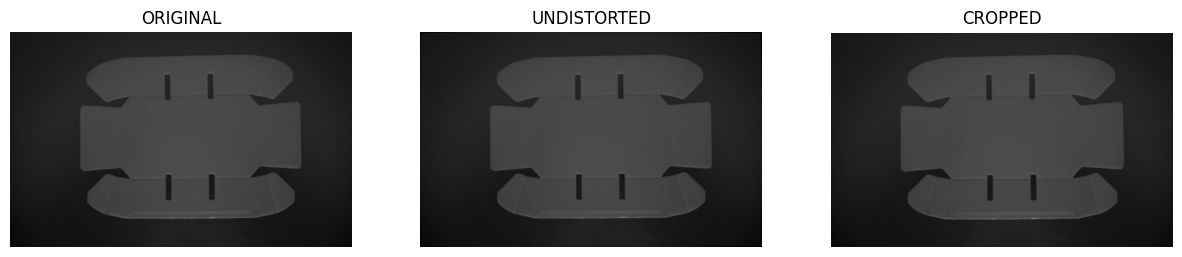

In [144]:
# We find the dimensions of the image
h, w = image.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(image, mtx, dist, None, newcameramtx)

# We crop the image using the ROI
x_r, y_r, w_r, h_r = roi
udst_crop_img = udst_img[y_r:y_r+h_r, x_r:x_r+w_r]

# We show the images
plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(udst_img, cmap="gray", vmin=0, vmax=255)
plt.title("UNDISTORTED")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

# Preprocesamiento

In [145]:
# Convertir de BGR (formato de OpenCV) a RGB para visualización
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Paso 1: Convertir a escala de grises
#gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Paso 2: Aplicar desenfoque Gaussiano para reducir ruido
blurred = cv.GaussianBlur(image, (5, 5), 0)

(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

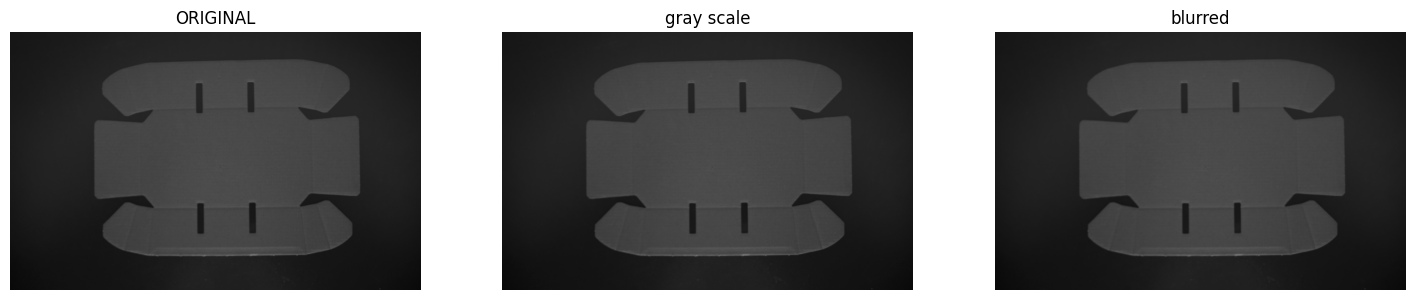

In [146]:
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plt.imshow(image_rgb, vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(image, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("gray scale")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(blurred, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("blurred")
plt.axis("off")

# Region of interest

(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

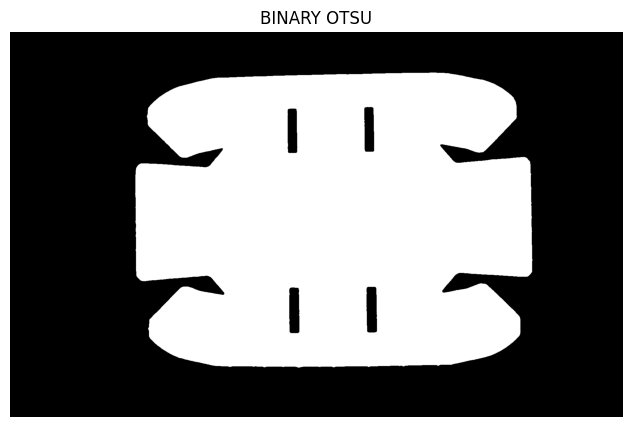

In [147]:
# Thresholding the imnage OTSU gives us the optimal threshold value
_ , th_Bin_OTSU = cv.threshold(blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Let's see the results
plt.figure(figsize=(10, 5))
plt.imshow(th_Bin_OTSU, cmap="gray", vmin=0, vmax=255) 
plt.title("BINARY OTSU")
plt.axis("off")

Cardboard area detection

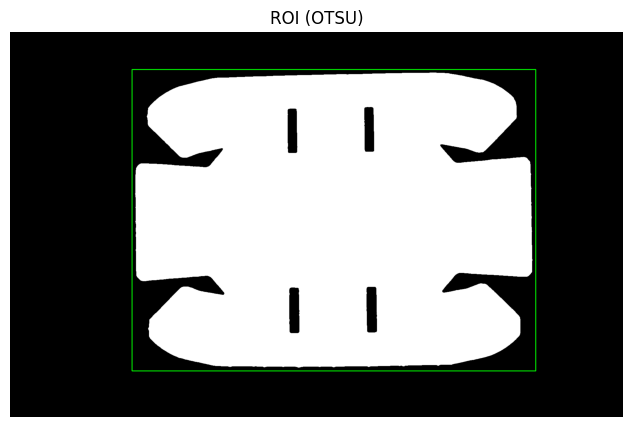

In [148]:
# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 10  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)  #With ROI coordinates we can select the desired part of the image

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
plt.figure(figsize=(10, 5))
plt.imshow(img_with_roi)
plt.title("ROI (OTSU)")
plt.axis("off")
plt.show()



# Separating area of interest

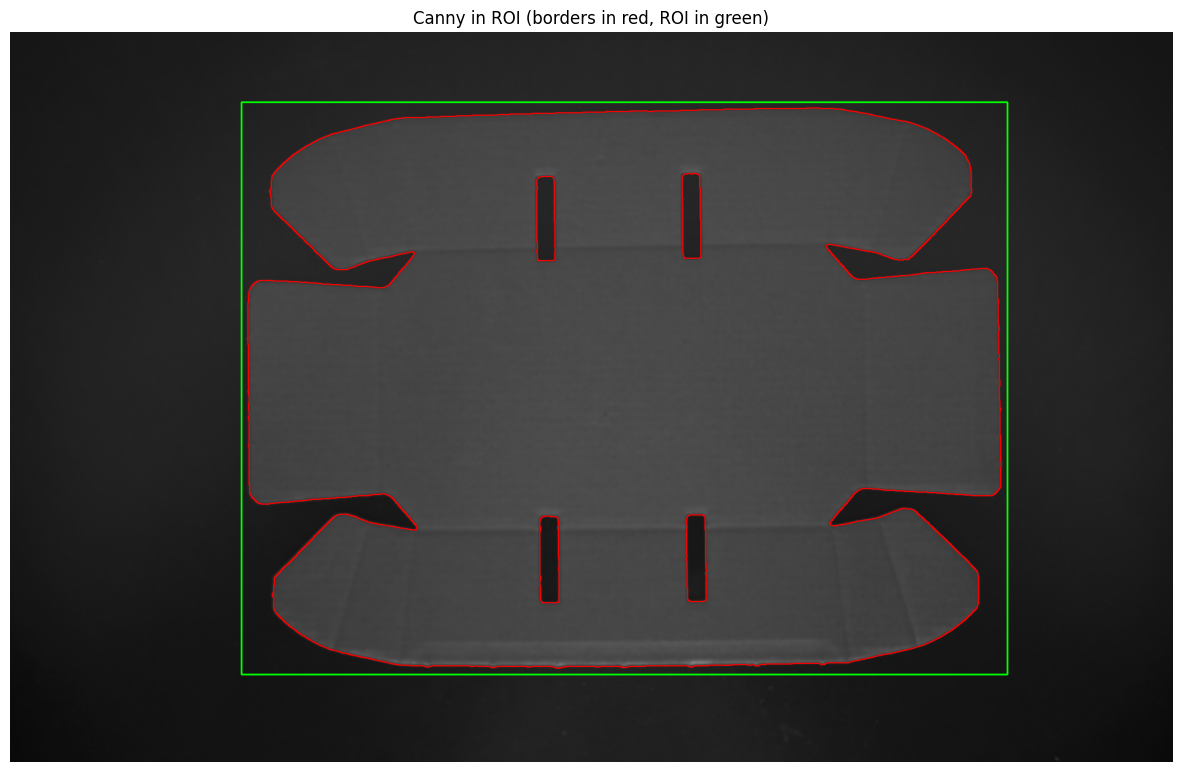

In [149]:
# We use the ROI found in the previous step
roi = th_Bin_OTSU[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the canny on the ROI
canny_edges_roi = cv.Canny(roi, 40, 120, L2gradient=True)
# print("Borders detected:", np.count_nonzero(canny_edges_roi))

# Dilate the edges
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# we make a color copy of the image
img_copy =  blurred.copy()
img_color_copy = cv.cvtColor(img_copy, cv.COLOR_GRAY2BGR)

# We draw the edges in red on the original image
mask = canny_edges > 0

# We draw the edges in red on the original image
roi_color = img_color_copy[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_color[mask] = [0, 0, 255] # red (BGR)

# We draw a rectangle of the ROI in green
cv.rectangle(img_color_copy, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# The results are shown
plt.figure(figsize=(15, 10))
plt.title("Canny in ROI (borders in red, ROI in green)")
plt.imshow(cv.cvtColor(img_color_copy, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Lines inside of the contours of the cardboard

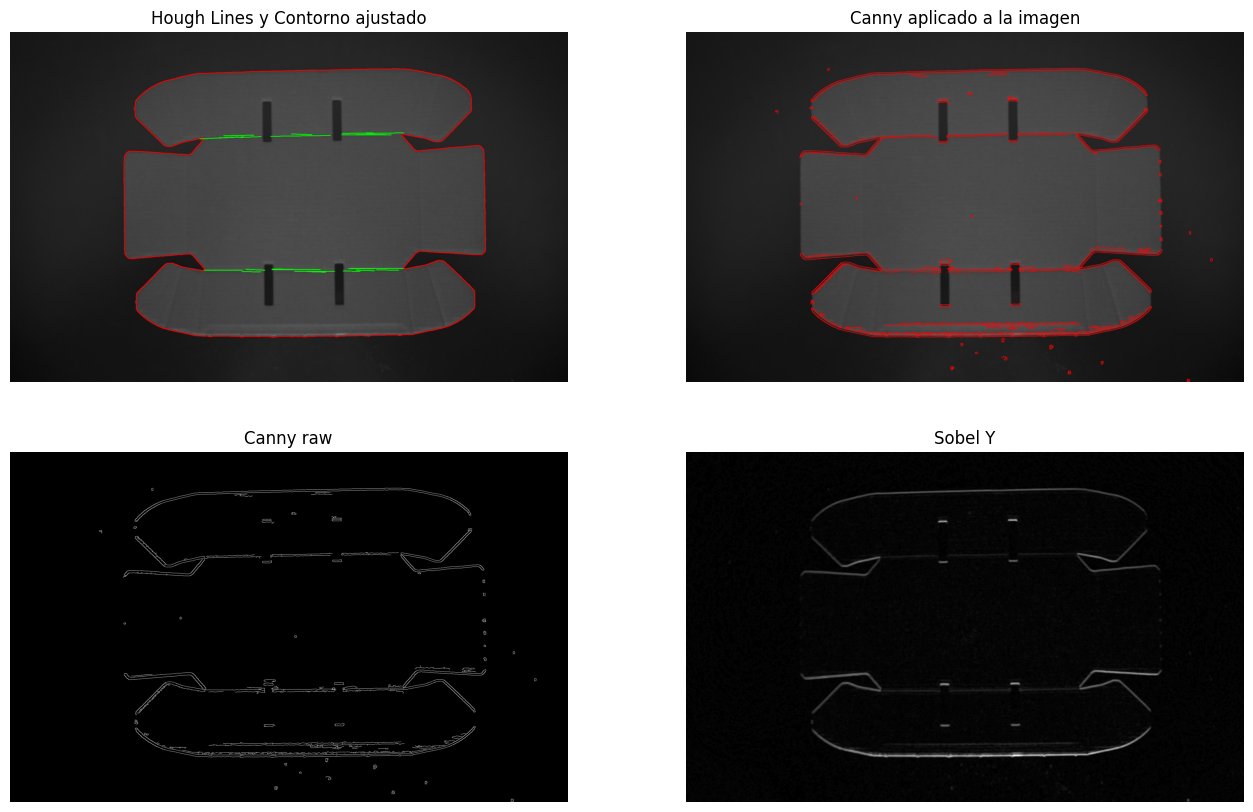

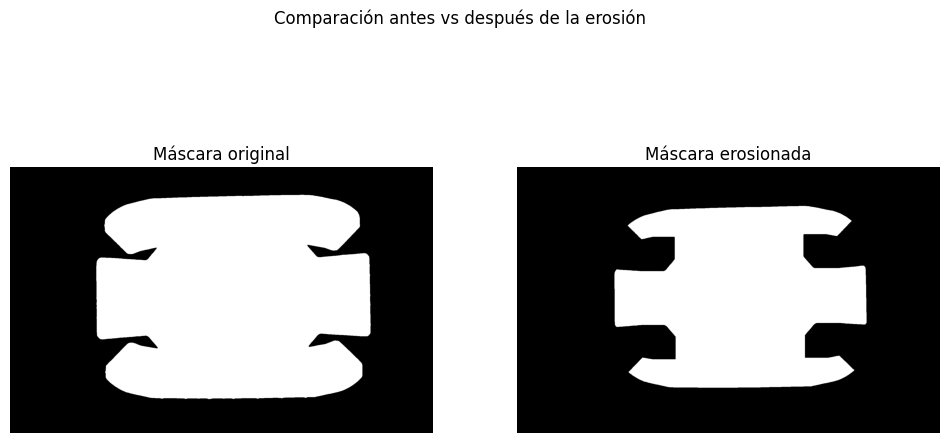

In [150]:
# Crear máscara del mismo tamaño que la imagen, inicialmente negra
contour_mask = np.zeros_like(blurred, dtype=np.uint8)

# Obtener el contorno más grande en la imagen (dentro del ROI binarizado)
contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv.contourArea)

# Usar contorno real en lugar del convex hull
contour_offset = max_contour + np.array([[[x_roi, y_roi]]])

# Dibujar el contorno exterior (relleno blanco) sobre la máscara
cv.drawContours(contour_mask, [contour_offset], -1, color=255, thickness=-1)

# Aplicar erosión para "encoger" el área del contorno
mask_size = 100 # tamaño del kernel de erosión
kernel = np.ones((mask_size, mask_size), np.uint8)  # puedes ajustar el tamaño para más o menos reducción
contour_mask_eroded = cv.erode(contour_mask, kernel, iterations=1)


# Aplicar filtro Sobel en Y (resalta líneas verticales)
sobel_y = cv.Sobel(blurred, cv.CV_64F, 0, 1, 3)

# Convertir a escala de 8 bits para usar con Canny
sobel_y_abs = (np.absolute(sobel_y))

# Normalizar a rango 0-255
sobel_y_norm = cv.normalize(sobel_y_abs, None, 0, 255, cv.NORM_MINMAX)
sobel_y_uint8 = np.uint8(sobel_y_norm)
sobel_dilate = cv.dilate(sobel_y_uint8, np.ones((3,3)), iterations=1)

# Aplicar Canny a la imagen filtrada por Sobel
edges = cv.Canny(sobel_dilate, 20, 60, L2gradient=True)
edges_dilated = cv.dilate(edges, np.ones((2,2)), iterations=1)
lines = cv.HoughLinesP(edges_dilated, 2, np.pi/180, threshold=50, minLineLength=60, maxLineGap=10)

lineas_filtradas = []

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Revisar si ambos puntos están dentro de la máscara blanca (valor 255)
        xm = int((x1 + x2) / 2)
        ym = int((y1 + y2) / 2)
        if contour_mask_eroded[ym, xm] == 255:
            lineas_filtradas.append((x1, y1, x2, y2))
            
            
output = cv.cvtColor(blurred, cv.COLOR_GRAY2BGR)
# Dibujar el contorno ajustado en rojo
cv.drawContours(output, [contour_offset], -1, (0, 0, 255), 2)  # color rojo


for x1, y1, x2, y2 in lineas_filtradas:
    cv.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Copiar imagen original a color para dibujar bordes
output_canny = cv.cvtColor(blurred, cv.COLOR_GRAY2BGR)
output_canny[edges_dilated > 0] = [0, 0, 255]  # rojo

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.title("Hough Lines y Contorno ajustado")
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 2, 2)
plt.title("Canny aplicado a la imagen")
plt.imshow(cv.cvtColor(output_canny, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 2, 3)
plt.title("Canny raw")
plt.imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2, 2, 4)
plt.title("Sobel Y")
plt.imshow(cv.cvtColor(sobel_dilate, cv.COLOR_BGR2RGB))
plt.axis("off")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(contour_mask, cmap='gray')
axs[0].set_title("Máscara original")
axs[0].axis('off')
axs[1].imshow(contour_mask_eroded, cmap='gray')
axs[1].set_title("Máscara erosionada")
axs[1].axis('off')
plt.suptitle("Comparación antes vs después de la erosión")
plt.show()

# Grouping / clustering lines

Número de clusters encontrados: 13


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

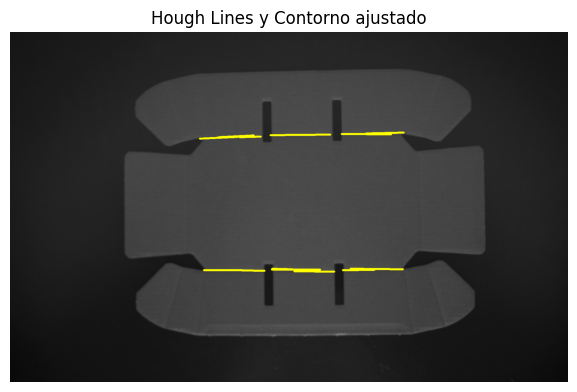

In [151]:
def get_line_features(x1, y1, x2, y2):
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    return [center_x, center_y, angle]

# Construir datos para clustering
features = [get_line_features(x1, y1, x2, y2) for x1, y1, x2, y2 in lineas_filtradas]
X = np.array(features)

# Ajustamos el peso: 
# - menos importancia a X (horizontal),
# - más a Y (vertical),
# - menos al ángulo (para evitar que el ángulo cause separación innecesaria)
#X[:, 0] /= 40.0     # X (horizontal) — reducir impacto
#X[:, 1] /= 1.0     # Y (vertical) — mantener fuerte impacto
X[:, 2] /= 15.0  # normaliza el ángulo

# Clustering DBSCAN
clustering = DBSCAN(eps=40, min_samples=1).fit(X)
labels = clustering.labels_

grouped_lines = defaultdict(list)
for label, (x1, y1, x2, y2) in zip(labels, lineas_filtradas):
    if label != -1:  # Ignorar ruido
        grouped_lines[label].append(((x1, y1), (x2, y2)))

def fuse_lines(line_group):
    points = [pt for line in line_group for pt in line]
    [vx, vy, x0, y0] = cv.fitLine(np.array(points), cv.DIST_L2, 0, 0.01, 0.01)
    vx, vy = vx[0], vy[0]
    x0, y0 = x0[0], y0[0]
    
    # Proyectar hacia los extremos del grupo
    lengths = [np.dot([x - x0, y - y0], [vx, vy]) for x, y in points]
    min_len, max_len = min(lengths), max(lengths)
    
    p1 = (int(x0 + vx * min_len), int(y0 + vy * min_len))
    p2 = (int(x0 + vx * max_len), int(y0 + vy * max_len))
    return p1, p2

output_cluster_lines = cv.cvtColor(blurred, cv.COLOR_GRAY2BGR)

for group in grouped_lines.values():
    p1, p2 = fuse_lines(group)
    cv.line(output_cluster_lines, p1, p2, (0, 255, 255), 5)  # amarillo

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Número de clusters encontrados:", n_clusters)

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.title("Hough Lines y Contorno ajustado")
plt.imshow(cv.cvtColor(output_cluster_lines, cv.COLOR_BGR2RGB))
plt.axis("off")

# Focus Areas Division

Punto más arriba: (np.int64(1346), np.int64(127))
Punto más abajo: (np.int64(916), np.int64(1060))
Punto más a la izquierda: (np.int64(394), np.int64(512))
Punto más a la derecha: (np.int64(1650), np.int64(716))


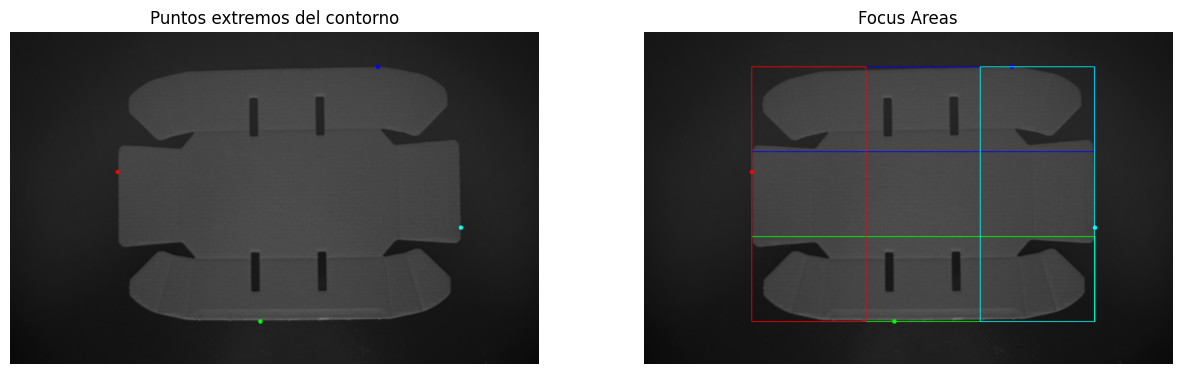

In [152]:
# We find the contours of the image
contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We only keep the contours with the maximum area
max_contour = max(contours, key=cv.contourArea)

# We calculate the convex hull of the maximum contour
hull = cv.convexHull(max_contour)

# We add the offset of the ROI to the convex hull
hull_offset = hull + np.array([[[x_roi, y_roi]]])

# We draw the convex hull in red color
contour_img = cv.cvtColor(udst_crop_img, cv.COLOR_GRAY2BGR)
cv.drawContours(contour_img, [hull_offset], -1, (0,0,255), 2)

# Encuentra los puntos extremos
topmost    = tuple(hull_offset[hull_offset[:,:,1].argmin()][0])
bottommost = tuple(hull_offset[hull_offset[:,:,1].argmax()][0])
leftmost   = tuple(hull_offset[hull_offset[:,:,0].argmin()][0])
rightmost  = tuple(hull_offset[hull_offset[:,:,0].argmax()][0])

print("Punto más arriba:", topmost)
print("Punto más abajo:", bottommost)
print("Punto más a la izquierda:", leftmost)
print("Punto más a la derecha:", rightmost)


# Copiamos la imagen original para dibujar los puntos
th_COPy_COLOR = cv.cvtColor(blurred, cv.COLOR_GRAY2BGR)

# Opcional: dibuja los puntos en la imagen
for pt, color in zip([topmost, bottommost, leftmost, rightmost], [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]):
    cv.circle(th_COPy_COLOR, pt, 8, color, -1)

# Paso 1: calcular el bounding box de la caja
x_min = leftmost[0]
x_max = rightmost[0]
y_min = topmost[1]
y_max = bottommost[1]

width = x_max - x_min
height = y_max - y_min

# Paso 2: calcular divisiones por tercios
third_width = width // 3
third_height = height // 3

# --- Áreas horizontales (de arriba a abajo) ---
area_top    = (x_min, y_min, width, third_height)
area_bottom = (x_min, y_min + 2 * third_height, width, third_height)

# --- Áreas verticales (de izquierda a derecha) ---
area_left   = (x_min, y_min, third_width, height)
area_right  = (x_min + 2 * third_width, y_min, third_width, height)

# --- OPCIONAL: si quisieras usar mitades en lugar de tercios, cambia esto ---
# half_width = width // 2
# half_height = height // 2
# area_left = (x_min, y_min, half_width, height)
# area_right = (x_min + half_width, y_min, half_width, height)

# Paso 3: visualizar las regiones en la imagen
output = th_COPy_COLOR.copy()
def draw_area(blurred, rect, color):
    x, y, w, h = rect
    cv.rectangle(blurred, (x, y), (x + w, y + h), color, 2)

# Dibujar regiones
draw_area(output, area_top, (255, 0, 0))      # azul
draw_area(output, area_bottom, (0, 255, 0))   # verde
draw_area(output, area_left, (0, 0, 255))     # rojo
draw_area(output, area_right, (255, 255, 0))  # amarillo

# Mostrar resultado
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Puntos extremos del contorno")
plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(2,2,2)
plt.title("Focus Areas")
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()